# Saddle point systems

In [1]:
using Revise

In [1]:
using ViscousFlow

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousFlow/2kdbn.ji for ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1240


In [3]:
using LinearAlgebra

In [42]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

┌ Warning: /Users/jeff/.julia/packages/Plots/RsO3g/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /Users/jeff/.julia/packages/Revise/MgvIv/src/Revise.jl:492


In [7]:
using Pkg
pkg"test ViscousFlow"

   Testing ViscousFlow
 Resolving package versions...
Test Summary: | Pass  Total
PointForce    |   13     13
Test Summary: | Pass  Total
Grid Routines |   84     84
Test Summary:         | Pass  Total
Complex Grid Routines |   73     73
Test Summary: | Pass  Total
Fields        |   27     27
Test Summary:        | Pass  Total
Point-Field Routines |   64     64
Test Summary: | Pass  Total
Double Layer  |    2      2
Test Summary: | Pass  Total
Single Layer  |    2      2
Test Summary: | Pass  Total
Masks         |    1      1
Test Summary:        | Pass  Total
Saddle-Point Systems |   33     33
Test Summary: | Pass  Total
Time Marching |    3      3
Test Summary: | Pass  Total
Navier-Stokes |   27     27
   Testing ViscousFlow tests passed 


In [84]:
?SaddleSystem

search: SaddleSystem SaddlePointSystems



```
SaddleSystem
```

Construct a saddle-point system operator from the constituent operator blocks. The resulting object can be used with `*` and `\` to multiply and solve. The saddle-point problem has the form

$\begin{bmatrix}A & B_1^T \\ B_2 & C \end{bmatrix} \begin{pmatrix} u \\ f \end{pmatrix} = \begin{pmatrix} r_1 \\ r_2 \end{pmatrix}$

### Constructors

`SaddleSystem(A::AbstractMatrix,B₂::AbstractMatrix,B₁ᵀ::AbstractMatrix,C::AbstractMatrix[,eltype=Float64])`. Blocks are given as matrices. Must have consistent sizes to stack appropriately. If this is called with `SaddleSystem(A,B₂,B₁ᵀ)`, it sets `C` to zero automatically.

`SaddleSystem(A,B₂,B₁ᵀ,C,u,f[,eltype=Float64])`. Operators `A`, `B₂`, `B₁ᵀ`, `C` are given in various forms, including matrices, functions, and function-like objects. `u` and `f` are examples of the data types in the corresponding solution and right-hand side vectors. Guidelines:

  * The entries `A` and `B₂` must be able to act upon `u` (either by multiplication or as a function) and `B₁ᵀ` and `C` must be able to act on `f` (also, either by multiplication or as a function).
  * `A` and `B₁ᵀ` should return data of type `u`, and `B₂` and `C` should return data of type `f`.
  * `A` must be invertible and be outfitted with operators ``and`ldiv!`.
  * Both `u` and `f` must be subtypes of `AbstractArray`: they must be equipped with `size` and `vec` functions and with a constructor of the form `T(data)` where `T` is the data type of `u` or `f` and `data` is the wrapped data array.

If called as `SaddleSystem(A,B₂,B₁ᵀ,u,f)`, the `C` block is omitted and assumed to be zero.

If called with `SaddleSystem(A,u)`, this is equivalent to calling `SaddleSystem(A,nothing,nothing,u,[])`, then this reverts to the unconstrained system described by operator `A`.

The list of vectors in any of these constructors can be replaced by a `SaddleVector`, e.g. `SaddleSystem(A,B₂,B₁ᵀ,SaddleVector(u,f))`.


### Working with matrices
Let's see how `SaddleSystems` work with matrices. We will solve the system

$$
\begin{bmatrix} 1 & 2 & 2 & -1 \\ 2 & 1 & 3 & -1 \\ 2 & 3 & 5 & -2\\ -1 & -1 & 3 & -4\end{bmatrix} \begin{pmatrix}s_1 \\ s_2 \\ s_3 \\ s_4 \end{pmatrix} = \begin{pmatrix} 1 \\ 2 \\ 3\\ 4\end{pmatrix}
$$

In [23]:
A = [1.0 2.0; 2.0 1.0] 
B2 = [2.0 3.0;-1.0 -1.0]
B1t = B2'
C =  [5.0 -2.0; 3.0 -4.0]
rhs1v = [1.0,2.0];
rhs2v = [3.0,4.0];

#### Let's first get the solution the usual way

In [12]:
Amat = [A B1t; B2 C]
rhsv = [rhs1v;rhs2v];

In [13]:
@time solv = Amat\rhsv

  1.418325 seconds (3.79 M allocations: 182.837 MiB, 18.15% gc time)


4-element Array{Float64,1}:
  5.551115123125783e-17
 -0.3571428571428571   
  0.6428571428571428   
 -0.4285714285714286   

#### Now let's solve as a SaddleSystem
We will divide this into four 2x2 blocks

In [14]:
As = SaddleSystem(A,B2,B1t,C)

Saddle system with 2 states and 2 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Float64,1}
   Elements of type Float64
using a Direct solver


We can solve this the same way, using `\` on the $4x1$ vector `rhsv`

In [14]:
@time As\rhsv

  0.000055 seconds (30 allocations: 1.375 KiB)


4-element Array{Float64,1}:
 -4.440892098500626e-16
 -0.35714285714285704  
  0.6428571428571431   
 -0.42857142857142827  

#### Iterative solver
The default is to store the Schur complement matrix, factorize it, and solve the problem directly. We can also use an iterative solver, specified with the `solver = ` keyword argument. The choices are `Direct` (default), `CG`, `BiCGStabl`, `GMRES`, `MINRES`, and `IDRS`. The `CG` and `MINRES` methods should only be used for symmetric systems. These iterative solvers make use of the `IterativeSolvers` package, and their optional arguments can be included in the `SaddleSystem` call.

In [15]:
As_iter = SaddleSystem(A,B2,B1t,C,solver=BiCGStabl)

Saddle system with 2 states and 2 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Float64,1}
   Elements of type Float64
using a BiCGStabl solver


In [17]:
@time As_iter\rhsv

  0.000085 seconds (108 allocations: 7.891 KiB)


4-element Array{Float64,1}:
  1.2212453270876722e-15
 -0.3571428571428574    
  0.6428571428571418    
 -0.4285714285714299    

#### More general form
The previous form of constructor works only for matrices. A more general form requires that we tell it the form of the *state* and *constraint* parts of the solution and right-hand side vectors. We can use `SaddleVector` to assemble these together into a single vector:

In [18]:
rhs = SaddleVector(rhs1v,rhs2v)

([1.0, 2.0], [3.0, 4.0])

The vector `rhs` is an `ArrayPartition` type:

In [19]:
typeof(rhs)

RecursiveArrayTools.ArrayPartition{Float64,Tuple{Array{Float64,1},Array{Float64,1}}}

Here, we construct the system:

In [20]:
@time As = SaddleSystem(A,B2,B1t,C,rhs)

  0.778444 seconds (1.82 M allocations: 90.965 MiB, 4.20% gc time)


Saddle system with 2 states and 2 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Float64,1}
   Elements of type Float64
using a Direct solver


and solve it in the usual way:

In [22]:
@time sol = As\rhs

  0.000041 seconds (40 allocations: 2.250 KiB)


([0.0, -0.3571428571428572], [0.6428571428571428, -0.42857142857142877])

The solution is of the same `ArrayPartition form`

In [23]:
typeof(sol)

RecursiveArrayTools.ArrayPartition{Float64,Tuple{Array{Float64,1},Array{Float64,1}}}

We can get the *state* and *constraint* parts of any `SaddleVector` with convenience functions:

In [24]:
state(sol)

2-element Array{Float64,1}:
  0.0               
 -0.3571428571428572

In [25]:
constraint(sol)

2-element Array{Float64,1}:
  0.6428571428571428 
 -0.42857142857142877

We can also multiply:

In [26]:
As*sol

([1.0, 2.0], [2.9999999999999996, 4.0])

### Unconstrained solution
Of course, we can use this with *unconstrained* systems without problem. For example, let's consider our example as the full matrix. We pass in an empty vector for the constraints:

In [28]:
nada = empty(rhsv);
rhsnc = SaddleVector(rhsv,nada)
Anc = SaddleSystem(Amat,rhsnc)

Saddle system with 4 states and 0 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Type{Float64},1}
   Elements of type Float64
using a Direct solver


In [29]:
solnc = Anc\rhsnc

([5.551115123125783e-17, -0.3571428571428571, 0.6428571428571428, -0.4285714285714286], Float64[])

In [30]:
state(solnc)

4-element Array{Float64,1}:
  5.551115123125783e-17
 -0.3571428571428571   
  0.6428571428571428   
 -0.4285714285714286   

In [31]:
constraint(solnc)

0-element Array{Float64,1}

And if we multiply, we get back what we expect:

In [32]:
Anc*solnc

([1.0, 2.0, 3.0, 4.0], Float64[])

### More interesting operators
Let's try this on `ViscousFlow` field operators. We will construct a square grid of points and immerse a bunch of points in it. Our goal is to solve

$$
\begin{bmatrix} L & R \\ E & 0 \end{bmatrix} \begin{pmatrix} \psi \\ f \end{pmatrix} =  \begin{pmatrix} -w \\ \psi_b \end{pmatrix}
$$

where $\psi$ is the discrete streamfunction, $w$ the discrete vorticity, and $\psi_b$ a prescribed distribution of streamfunction on the body surface.

In [33]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
u = similar(w);

Set up a Laplace operator on this grid, and make sure it has an inverse:

In [34]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 130, ny = 130) grid acting on Float64 data with spacing 1.0

Set up points along a circle

In [35]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ[1:n])
yb = 1.0 .+ R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
ψb = ScalarData(X);

Create the regularization and interpolation operators:

In [36]:
E = Regularize(X,dx;issymmetric=true)
Rmat,Emat = RegularizationMatrix(E,ψb,w);

Now we set up the system

In [38]:
u = SaddleVector(w,ψb);
@time A = SaddleSystem(L,Emat,Rmat,u) #,solver=BiCGStabl,tol=1e-3)

  0.235366 seconds (5.01 k allocations: 100.400 MiB, 12.39% gc time)


Saddle system with 16900 states and 128 constraints and
   State vector of type Nodes{Dual,130,130,Float64,Array{Float64,2}}
   Constraint vector of type ScalarData{128,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


and the right-hand side vector

In [39]:
ψb .= -(xb .- 1);
rhs = SaddleVector(w,ψb)

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [-0.5, -0.4993977281025863, -0.4975923633360986, -0.49458825498239056, -0.4903926402016152, -0.48501562659727204, -0.4784701678661043, -0.47077203259151035, -0.4619397662556435, -0.4519946465617217  …  -0.44096063217417747, -0.4519946465617215, -0.46193976625564326, -0.47077203259151035, -0.4784701678661043, -0.48501562659727204, -0.4903926402016152, -0.49458825498239056, -0.4975923633360986, -0.4993977281025863])

and solve it...

In [41]:
@time sol = A\rhs;

  0.002445 seconds (70 allocations: 1.296 MiB)


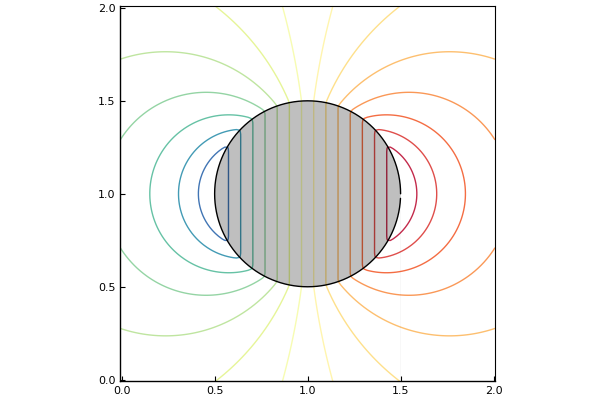

In [43]:
xg,yg = coordinates(w,dx=dx)
plot(xg,yg,state(sol))
plot!(xb,yb,xlim=(-Inf,Inf),ylim=(-Inf,Inf),fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Plot the constraint vector and compare it with the exact solution (for the continuous problem):

In [44]:
fex = -2*cos.(θ[1:n])*ds;

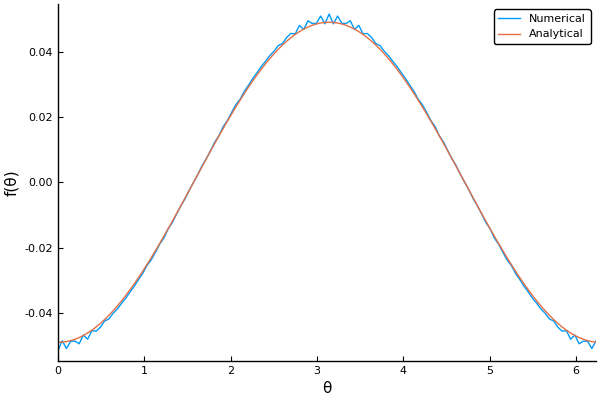

In [45]:
plot(θ[1:n],constraint(sol),label="Numerical",xlabel="θ",ylabel="f(θ)",xlim=(-Inf,Inf))
plot!(θ[1:n],fex,label="Analytical")

The L2 norm of the difference

In [46]:
norm(constraint(sol)-fex)

0.010176487612409175

### Unconstrained case with Edges data

In [47]:
rhsq = Edges(Primal,w);
rhsq.u .= 3;

In [48]:
Aq = SaddleSystem(I,SaddleVector(rhsq,nada));

In [52]:
@time sol = Aq\SaddleVector(rhsq,nada)

  0.000849 seconds (260 allocations: 1.548 MiB)


(Primal edges for a (nx = 130, ny = 130) cell grid of type Float64 data
  Internal u-faces: (nx = 130, ny = 129)
  Internal v-faces: (nx = 129, ny = 130), Float64[])

In [53]:
q = state(sol);

In [54]:
all(q.u .== 3.0) && all(q.v .== 0.0)

true

### Filtering
Sometimes we might wish to apply a linear filter to the solution for the constraint forces. We can define such a filter in the same way that we define the other operators. It is passed in via the `filter=` keyword argument. This argument defaults to the identity.

Let's try this on our earlier example, using the filtering operation associated with Regularization/Interpolation with re-scaling:

In [56]:
Ẽ = Regularize(X,dx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(Ẽ,ψb,w);
Ẽmat = InterpolationMatrix(Ẽ,w,ψb);

We define our filtering operator as a product of these two operators:

In [68]:
Pmat = Ẽmat*H̃mat;

In [79]:
u = SaddleVector(w,ψb);
Afilt = SaddleSystem(L,Emat,Rmat,u,filter=Pmat)

Saddle system with 16900 states and 128 constraints and
   State vector of type Nodes{Dual,130,130,Float64,Array{Float64,2}}
   Constraint vector of type ScalarData{128,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


In [80]:
ψb .= -(xb .- 1);
rhs = SaddleVector(w,ψb);

In [81]:
sol = Afilt\rhs;

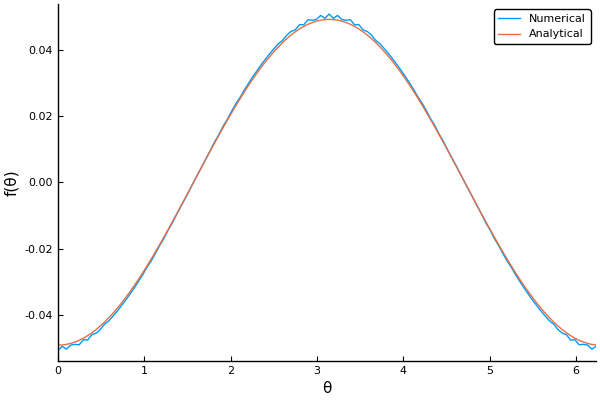

In [82]:
plot(θ[1:n],constraint(sol),label="Numerical",xlabel="θ",ylabel="f(θ)",xlim=(-Inf,Inf))
plot!(θ[1:n],fex,label="Analytical")

Notice that the solution is less noisy than without it, and the comparison with the exact result is more favorable:

In [83]:
norm(constraint(sol)-fex)

0.008383851513019288

### Another interesting example
This time, we will solve a similar problem, but this time setting a surface velocity (requiring `VectorData`) and determining the vorticity (the state vector):


$$
\begin{bmatrix} I & C^{T}R \\ -ECL^{-1} & 0 \end{bmatrix} \begin{pmatrix} w \\ f \end{pmatrix} =  \begin{pmatrix} 0 \\ u_b \end{pmatrix}
$$

where $I$ is the identity and $u_b$ is the surface velocity.

In [51]:
# surface velocity
ub = VectorData(X);

# a grid velocity field
q = Edges(Primal,w);

# and regularization and interpolation operators
Rvmat,Evmat = RegularizationMatrix(E,ub,q);

Now, define the state-constraint operators as functions

In [52]:
B₁ᵀ(f) = Curl()*(Rvmat*f);

In [53]:
B₂(w) = -(Evmat*(Curl()*(L\w)))

B₂ (generic function with 1 method)

In [54]:
rhs = SaddleVector(w,ub)
A = SaddleSystem(I,B₂,B₁ᵀ,rhs)

Saddle system with 16900 states and 256 constraints and
   State vector of type Nodes{Dual,130,130,Float64}
   Constraint vector of type VectorData{128,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


In [55]:
ub.u .= 0.0 #-sin.(4θ[1:n]);
ub.v .= 1.0 # cos.(4θ[1:n]);
#rhs = SaddleVector(w,ub); 

Note that the assignements to `ub` automatically update the `rhs` vector:

In [58]:
constraint(rhs)

128 points of vector-valued Float64 data
256-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [48]:
sol = A\rhs;

Plot the streamlines:

In [75]:
ψ = -(L\state(sol));

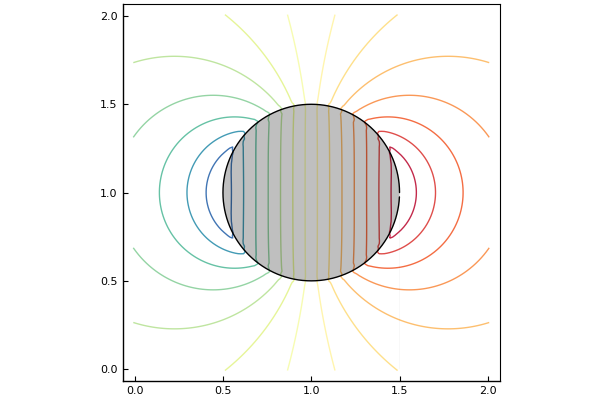

In [76]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

#### Now, we will solve the same problem, but with diffusion, handled by an integrating factor

$$
\begin{bmatrix} H(-\Delta t) & C^{T}R \\ -ECL^{-1} & 0 \end{bmatrix} \begin{pmatrix} w \\ f \end{pmatrix} =  \begin{pmatrix} 0 \\ u_b \end{pmatrix}
$$

where $H(t)$ is the linear diffusion operator.

In [49]:
Δt = 2.0
Hdt = plan_intfact(Δt,w);

For this integrating factor, we will set up some basic operations. Since the integrating factor `Hdt` corresponds to $H(\Delta t)$, but $A$ in our saddle system is $H(-\Delta t)$, then the action of `Hdt` on grid data actually corresponds to the *backslash* operation of $A$ on that data. We won't use the multiplication operation of $A$ in our example, so we will just set it to the identity.

In [50]:
struct IFOperator
    op :: ViscousFlow.Fields.IntFact
end

In [51]:
import Base: \, *
\(A::IFOperator,w::Nodes) = A.op*w;
*(A::IFOperator,w::Nodes) = w; # identity, technically incorrect but never used in our example

Form the saddle-point system:

In [52]:
A = SaddleSystem(IFOperator(Hdt),B₂,B₁ᵀ,rhs)

Saddle system with 16900 states and 256 constraints and
   State vector of type Nodes{Dual,130,130,Float64}
   Constraint vector of type VectorData{128,Float64,Array{Float64,1}}
   Elements of type Float64


Solve it for surface velocity associated with a deforming surface.

In [53]:
ub.u .= cos.(4θ[1:n]);
ub.v .= -sin.(4θ[1:n]);
rhs = SaddleVector(w,ub);

In [54]:
sol = A\rhs

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [-26.207902970488334, -26.366906895221167, -23.696775376862245, -20.90449178873363, -16.45204166194476, -11.759499070574536, -5.685588252333794, -0.9276903205261744, 5.629450990956176, 9.812133566786027  …  -15.82929049444122, -18.219691233698672, -12.413843567956896, -16.1015330650991, -9.300856344391049, -10.624168563601506, -7.667628179924083, -4.923654850949798, -4.355812966014731, -1.5071488916849252])

Let's inspect the vorticity in this case:

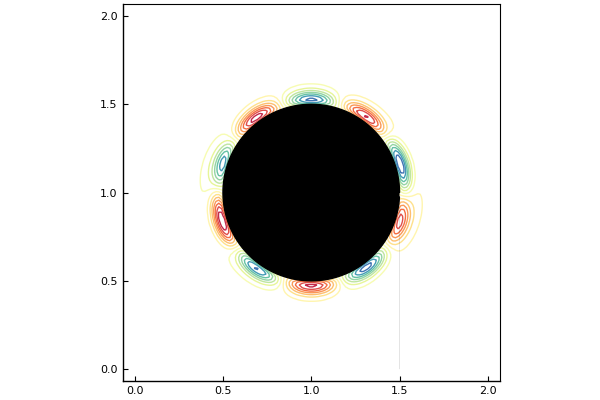

In [360]:
w = state(sol);
xg,yg = coordinates(w,dx=dx)
plot(xg,yg,w)
plot!(xb,yb,fillcolor=:black,fillrange=0,linecolor=:black)

### Set of saddle point systems
We can solve a **set** of saddle point systems. The ones we set up here are completely decoupled. We group the individual saddle point systems into a tuple:

In [55]:
sys = (A,Anc)

(Saddle system with 16900 states and 256 constraints and
   State vector of type Nodes{Dual,130,130,Float64}
   Constraint vector of type VectorData{128,Float64,Array{Float64,1}}
   Elements of type Float64
, Saddle system with 4 states and 0 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Type{Float64},1}
   Elements of type Float64
)

We provide a tuple of right-hand side vectors (each of type `SaddleVector`), and get a tuple of solutions:

In [56]:
sol1, sol2 = sys\(rhs,rhsnc);

In [57]:
sol1

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [-26.207902970488334, -26.366906895221167, -23.696775376862245, -20.90449178873363, -16.45204166194476, -11.759499070574536, -5.685588252333794, -0.9276903205261744, 5.629450990956176, 9.812133566786027  …  -15.82929049444122, -18.219691233698672, -12.413843567956896, -16.1015330650991, -9.300856344391049, -10.624168563601506, -7.667628179924083, -4.923654850949798, -4.355812966014731, -1.5071488916849252])

In [58]:
sol2

([5.551115123125783e-17, -0.3571428571428571, 0.6428571428571428, -0.4285714285714286], Float64[])

We can check that these are the same as the problems solved individually (since they are uncoupled in this example):

In [59]:
sol1 == sol

true

In [60]:
sys*(sol1,sol2)

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130)[1.0000000000000004, 0.9807852804032319, 0.9238795325112866, 0.8314696123025455, 0.707106781186549, 0.5555702330196018, 0.38268343236508895, 0.19509032201612733, 6.276346320751691e-16, -0.19509032201612836  …  0.9238795325112861, 0.9807852804032305, 0.9999999999999997, 0.9807852804032308, 0.9238795325112871, 0.8314696123025463, 0.7071067811865478, 0.5555702330196045, 0.38268343236508995, 0.19509032201612894], [1.0, 2.0, 3.0, 4.0]Float64[])

### Define minimal wrapper type
Here, we demonstrate the needs of a data wrapper for `SaddleSystem`

In [61]:
# Basic structure of the wrapper
struct MyWrapper{T,DT} <: AbstractVector{T}
    data :: DT
end

# Basic constructor
MyWrapper(data::AbstractVector{T}) where {T} = MyWrapper{eltype(data),typeof(data)}(data)

MyWrapper

In [62]:
# set up basic array stuff
Base.size(A::MyWrapper) = size(A.data)
Base.size(A::MyWrapper,d::Int) = size(A.data,d)
Base.@propagate_inbounds Base.getindex(A::MyWrapper,i::Int) = getindex(A.data,i)
Base.@propagate_inbounds Base.setindex!(A::MyWrapper, v, i::Int) = setindex!(A.data,v,i)
Base.similar(A::MyWrapper) = MyWrapper(similar(A.data))
Base.zero(A::MyWrapper{T,DT}) where {T,DT} = MyWrapper(zero(A.data))

In [63]:
# set up basic arithmetic so that matrix operators work on them properly
using LinearAlgebra
import LinearAlgebra: mul!,*,\
mul!(y::MyWrapper,A::Matrix,x::MyWrapper) = (mul!(y.data,A,x.data); return y)
(*)(A::Matrix,x::MyWrapper) = (y = similar(x); mul!(y,A,x); return y)
(\)(A::Matrix,x::MyWrapper) = (y = similar(x); y.data .= A\x.data; return y)

\ (generic function with 193 methods)

In [64]:
f = MyWrapper(1.0:5.0)

5-element MyWrapper{Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}:
 1.0
 2.0
 3.0
 4.0
 5.0

Return to the old matrix system

In [65]:
A = [1.0 2.0; 2.0 1.0] 
B2 = [2.0 3.0;-1.0 -1.0]
B1t = B2'
C =  [5.0 -2.0; 3.0 -4.0]
rhs1v = [1.0,2.0];
rhs2v = [3.0,4.0];

In [66]:
rhs1 = MyWrapper(rhs1v)
rhs2 = MyWrapper(rhs2v);
rhs = SaddleVector(rhs1,rhs2)

([1.0, 2.0], [3.0, 4.0])

In [67]:
@time As = SaddleSystem(A,B2,B1t,C,rhs)

  0.576206 seconds (1.42 M allocations: 68.315 MiB, 5.37% gc time)


Saddle system with 2 states and 2 constraints and
   State vector of type MyWrapper{Float64,Array{Float64,1}}
   Constraint vector of type MyWrapper{Float64,Array{Float64,1}}
   Elements of type Float64


In [68]:
@time sol = As\rhs

  0.354179 seconds (946.51 k allocations: 47.009 MiB, 8.49% gc time)


([0.0, -0.3571428571428572], [0.6428571428571428, -0.42857142857142877])

In [69]:
As*sol

([1.0, 2.0], [2.9999999999999996, 4.0])

### [WIP] Saddle system of a saddle system

First, try a basic matrix system

In [236]:
# A 3 x 3 upper left block, treated as a saddle system
A1 = Amat[1:2,1:2]
B21 = Amat[3:3,1:2];
B11t = B21';
C1 = Amat[3:3,3:3]
rhs11v = rhsv[1:2];
rhs12v = rhsv[3:3];

rhs1 = SaddleVector(rhs11v,rhs12v)

A = SaddleSystem(A1,B21,B11t,C1,rhs1)

Saddle system with 2 states and 1 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Float64,1}
   Elements of type Float64


In [342]:
# Now the constraint blocks for the outer saddle system
B22 = Amat[4:4,1:3];
B12t = Amat[1:3,4:4];
C2 = Amat[4:4,4:4];

# and the rhs for its constraint
rhs2 = rhsv[4:4];

rhsbig = SaddleVector(rhs1,rhs2)
#Abig = SaddleSystem(A,B22p,B12tp,C2,rhsbig);

In [341]:
y = B22p*(A\(B12tp*rhs2))

1-element Array{Float64,1}:
 -1.9999999999999987

In [267]:
B22p = ArrayPartition(view(B22,:,1:2),view(B22,:,3:3))
B12tp = ArrayPartition(view(B12t,1:2,:),view(B12t,3:3,:))

([-1.0; -1.0], [-2.0])

In [340]:
B22p*y

1-element Array{Float64,1}:
 -1.9999999999999987

In [337]:
function mul!(y::AbstractVector,Ap::ArrayPartition,x::ArrayPartition)
    fill!(y,0.0)
    for (i,A) in enumerate(Ap.x)
        y .+= A*vec(x.x[i])
    end
    return y
end
(*)(Ap::ArrayPartition{T},x::ArrayPartition{T}) where {T} = mul!(zeros(T,size(Ap.x[1],1)),Ap,x)

* (generic function with 504 methods)

In [336]:
vec(y.x[1])

2-element Array{Float64,1}:
 -4.440892098500626e-16
 -1.0                  

In [279]:
all(size.(B12tp.x,2) .== 1)

true

In [314]:
function mul!(y::ArrayPartition,Ap::ArrayPartition,x::AbstractVector)
    all(size.(Ap.x,2) .== 1) || error("Inconsistent column numbers in partition.")
    fill!(y,0.0)
    for (i,A) in enumerate(Ap.x)
        y.x[i] .+= A*x
    end
    return y
end
(*)(Ap::ArrayPartition{T},x::AbstractVector{T}) where {T} = mul!(similar(Ap,Float64,Float64),Ap,x)

* (generic function with 504 methods)

In [312]:
y = similar(B12tp,Float64,Float64)

([5.0e-324; 2.216656405e-314], [1.99196138e-315])

In [311]:
y.x[1]

2×1 Array{Array{Float64,1},2}:
 #undef
 #undef

In [315]:
B12tp*rhs2

([-4.0; -4.0], [-8.0])

In [159]:
@time convert(Vector,rhs1)

  0.000014 seconds (9 allocations: 400 bytes)


3-element Array{Float64,1}:
 1.0
 2.0
 3.0

In [152]:
B22*rhs1

DimensionMismatch: DimensionMismatch("result C has length 3, needs length 1")

In [16]:
# rhs1 is the RHS array for the inner saddle point system
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0;
#rhs1 = (rhs11,rhs12)
rhs1 = [rhs11;rhs12];
sol1 = zero(rhs1)

# rhs2 is the RHS array for the remainder of the outer saddle system
rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;
sol2 = zero(rhs2)

rhs = (rhs1,rhs2);
sol = (sol1,sol2);

In [17]:
Abig = SaddleSystem(A,B22,B12,C2,rhs1,rhs2);

In [18]:
sol = Abig\rhs

([-4.440892098500626e-16, -0.3571428571428571, 0.6428571428571432], [-0.4285714285714282])

In [19]:
out = Abig*sol

([1.0, 1.9999999999999998, 3.0000000000000004], [4.0])

In [20]:
norm(out[1]-rhs1)

4.965068306494546e-16